In [19]:
%cd ../..
%load_ext autoreload
%autoreload 2

/mnt/c/Users/vhli2/Documents
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [21]:
import numpy as np
import pandas as pd

# --- controls ---
amplitude = 15_000      # daily amplitude
mean_level = 30_000     # baseline
noise_std = 1_000       # Gaussian noise std
seasonal_month_amp = 0  # set >0 to add a slow monthly component to the signal

# 10-minute resolution from 2005-01-01 to 2024-12-31 23:00
time_index = pd.date_range("2005-01-01", "2024-12-31 23:00", freq="10min")  # '10min' is the canonical alias

# -------- daily phase (primary driver) --------
# fractional position within the day in [0,1)
day_start = time_index.normalize()
seconds_since_day_start = (time_index - day_start) / np.timedelta64(1, "s")
phase_day = seconds_since_day_start / (24 * 60 * 60)

# -------- optional monthly phase (for features and/or slow seasonality) --------
month_start = time_index.to_period("M").to_timestamp()
next_month_start = (time_index.to_period("M") + 1).to_timestamp()
month_len_hours = (next_month_start - month_start) / np.timedelta64(1, "h")
pos_hours = (time_index - month_start) / np.timedelta64(1, "h")
phase_month = pos_hours / month_len_hours  # in [0,1)

# -------- synthetic signal --------
rng = np.random.default_rng()  # or pass a seed: np.random.default_rng(42)

daily_component = amplitude * np.sin(2 * np.pi * (phase_day - 0.5))
monthly_component = seasonal_month_amp * np.sin(2 * np.pi * phase_month)  # optional slow drift
signal = mean_level + daily_component + monthly_component

noise = rng.normal(0.0, noise_std, size=len(time_index))
y = signal + noise

# -------- feature frame --------
df = pd.DataFrame(index=time_index)
df["demand"] = y

# sin/cos of hour-of-day (smooth cyclic encoding)
df["sin_hour"]  = np.sin(2 * np.pi * phase_day)
df["cos_hour"]  = np.cos(2 * np.pi * phase_day)

# sin/cos of monthly phase (kept for modeling slow seasonality; target remains daily-driven)
df["sin_month"] = np.sin(2 * np.pi * phase_month)
df["cos_month"] = np.cos(2 * np.pi * phase_month)

# optional extra convenience columns (not used in features below)
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek

features = ["sin_hour", "cos_hour", "sin_month", "cos_month"]

def split_features_target(df_in: pd.DataFrame, features=features):
    """
    Return (X, y) where X are time-derived sine/cosine features and y is demand.
    """
    X = df_in[features]
    y = df_in["demand"]
    return X, y


In [22]:
train_split_date = '01-Jan-2008'
val_split_date = '01-Jan-2009'

df_train = df.loc[df.index < train_split_date].copy()
df_val   = df.loc[(df.index >= train_split_date) & (df.index < val_split_date)].copy()
df_test  = df.loc[df.index >= val_split_date].copy()

In [23]:
class Args:
    def __init__(self):
        self.alpha = 300  # risk control level
        self.tightness = 85    # tightness parameter, may throw error if too low
        self.delta = 0.1        # failure probability or confidence parameter
        self.N = 4032            # number of 10-min intervals in 28 days
        self.lambda_min = 0.0
        self.lambda_safe = 1.0    # maximum value for lambda

        self.beta = 0.2
        self.gamma = None  # Not used here

args = Args()

In [24]:
def obtain_sf_and_sv(df_train_: pd.DataFrame, df_val_: pd.DataFrame):

    df_train_ = df.loc[df.index < train_split_date].copy()
    df_val_ = df.loc[(df.index >= train_split_date) & (df.index < val_split_date)].copy()

    reg = RandomForestRegressor(n_estimators=100, random_state=42)

    X_train_, y_train_ = split_features_target(df_train_)
    reg.fit(X_train_, y_train_)

    X_val_, y_val_ = split_features_target(df_val_)
    y_pred_ = reg.predict(X_val_)

    yt = y_val_
    ytm1 = y_val_.shift(1)
    ytm1.iloc[0] = 0.
    yht = pd.Series(y_pred_, index=y_val_.index)
    yhtm1 = yht.shift(1)
    yhtm1.iloc[0] = 0.

    left = yht + args.beta * yhtm1
    right = yt + args.beta * ytm1 - yht - args.beta * yhtm1
    ratios = right / left
    sf = ratios.quantile(0.95)
    coverage = (sf * left >= right).mean()
    print(f'Coverage in obtaining sf and sv: {coverage:.4f}, sf: {sf:.4f}')
    
    # Variance of production - demand gap
    lambda_grid = np.linspace(args.lambda_min, args.lambda_safe, 101)
    max_loss_var = -np.inf
    for lam in lambda_grid:
        Ut = (1 + sf * lam) * yht
        Utm1 = (1 + sf * lam) * yhtm1
        sample_losses = np.maximum(0, yt + args.beta * ytm1 - Ut - args.beta * Utm1)
        loss_var = np.var(sample_losses, ddof=1)
        if loss_var > max_loss_var:
            max_loss_var = loss_var
    print(f'Sample loss variance: {max_loss_var:.4f}')

    # tau
    tau = (sf * yht + args.beta * sf * yhtm1).quantile(0.95)
    print(f'tau: {tau:.4f}')

    return sf, loss_var, tau

In [25]:
sf, sample_variance, tau = obtain_sf_and_sv(df_train, df_val)

Coverage in obtaining sf and sv: 0.9500, sf: 0.0596
Sample loss variance: 377767.6293
tau: 3204.4330


In [26]:
reg = RandomForestRegressor(n_estimators=100, random_state=42)
X_train, y_train = split_features_target(df_train)
reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [27]:
args.starting_factor = sf
args.tau = tau

In [28]:
from rcpp.width_calculator import WidthCalculator
from scipy.stats import norm

class DemandErrorWidthCalculator(WidthCalculator):
    def __init__(self, sample_variance: float):
        self.sample_variance = sample_variance

    def get_width(self, delta_prime, N):
        return norm.ppf(1 - delta_prime / 2) * np.sqrt(self.sample_variance) / np.sqrt(N)

In [29]:
# Z to use: [Y_hat, Y]
from rcpp.performativity_simulator import PerformativitySimulator
from rcpp.loss_simulator import LossSimulator
from typing import Union, List

In [30]:
class DemandForecastingSimulator(PerformativitySimulator):
    def __init__(self, beta: float, starting_factor: float):
        """
        Arguments:
        - beta: the ratio of the load that is flexible and can be carried over by
            one hour. We assume that the load can be carried over by one hour only.
        """
        self.beta = beta
        self.starting_factor = starting_factor

    def simulate_shift(self,
                       Z_base: Union[List[np.ndarray], None],
                       lambda_: float) -> List[np.ndarray]:
        assert len(Z_base) == 2
        Y_hat, Y = Z_base

        U = (1 + self.starting_factor * lambda_) * Y_hat
        U_shifted = np.roll(U, 1)
        U_shifted[0] = 0  # Assume no carry-over for the first hour
        Y_shifted = np.roll(Y, 1)
        Y_shifted[0] = 0

        # New "demand," a function of the risk control parameter
        Y_bar = Y - self.beta * (U_shifted - Y_shifted)
        return [Y_hat, Y_bar]


class DemandForecastLossSimulator(LossSimulator):
    def __init__(self, starting_factor: float):
        self.starting_factor = starting_factor

    def calc_loss(self, Z: List[np.ndarray], lambda_: float, do_new_sample: bool = True, epsilon=1e-4) -> np.ndarray:
        assert len(Z) == 2
        Y_hat, Y = Z
        Y_produced = (1 + self.starting_factor * lambda_) * Y_hat
        loss = np.maximum(Y - Y_produced, 0)
        return loss


def demand_data_generator(start_date: str, n_samples: int = args.N):
    total_samples = len(df_test)
    current_idx = df_test.index.get_loc(pd.to_datetime(start_date))
    while current_idx + 2 * n_samples <= total_samples:
        chunk = df_test.iloc[current_idx:current_idx + 2 * n_samples]
        print(f"Dates: {chunk.index[0]} - {chunk.index[-1]}")
        X_chunk, y_chunk = split_features_target(chunk)
        y_chunk_hat = reg.predict(X_chunk)
        yield [y_chunk_hat, y_chunk]
        current_idx += n_samples


def splitter(Z: List[np.ndarray]):
    tot = len(Z[0])
    half = tot // 2
    Z_cal = [z[:half] for z in Z]
    Z_test = [z[half:] for z in Z]
    return Z_cal, Z_test

In [31]:
args.tau

3204.43302507982

In [32]:
from rcpp.risk_measure import MeanRiskMeasure
from rcpp.main import run_trajectory

width_calculator = DemandErrorWidthCalculator(sample_variance=sample_variance)
risk_measure = MeanRiskMeasure()
performativity_simulator = DemandForecastingSimulator(starting_factor=args.starting_factor, beta=args.beta)
loss_simulator = DemandForecastLossSimulator(starting_factor=args.starting_factor)
start_dates = pd.date_range(
    start=df_test.index[0],
    end=df_test.index[-1] - pd.Timedelta(days=30*30),
    freq="QS"  # quarterly frequency
)
print(start_dates)

tau = args.tau

trajs_controlled = []
trajs_uncontrolled = []
for start_date in start_dates:
    print(f"Starting new trajectory from {start_date.date()}")

    for tau_, trajs in [(tau, trajs_controlled), (0.0, trajs_uncontrolled)]:
        args.tau = tau_
        gen = demand_data_generator(start_date=start_date.strftime('%Y-%m-%d'))
        traj = run_trajectory(
            gen,
            splitter,
            width_calculator,
            risk_measure,
            performativity_simulator,
            loss_simulator,
            args,
        )
        trajs.append(traj)

DatetimeIndex(['2009-01-01', '2009-04-01', '2009-07-01', '2009-10-01',
               '2010-01-01', '2010-04-01', '2010-07-01', '2010-10-01',
               '2011-01-01', '2011-04-01', '2011-07-01', '2011-10-01',
               '2012-01-01', '2012-04-01', '2012-07-01', '2012-10-01',
               '2013-01-01', '2013-04-01', '2013-07-01', '2013-10-01',
               '2014-01-01', '2014-04-01', '2014-07-01', '2014-10-01',
               '2015-01-01', '2015-04-01', '2015-07-01', '2015-10-01',
               '2016-01-01', '2016-04-01', '2016-07-01', '2016-10-01',
               '2017-01-01', '2017-04-01', '2017-07-01', '2017-10-01',
               '2018-01-01', '2018-04-01', '2018-07-01', '2018-10-01',
               '2019-01-01', '2019-04-01', '2019-07-01', '2019-10-01',
               '2020-01-01', '2020-04-01', '2020-07-01', '2020-10-01',
               '2021-01-01', '2021-04-01', '2021-07-01', '2021-10-01',
               '2022-01-01', '2022-04-01', '2022-07-01'],
              dtype

Saved final loss plot to ./applications/forecasting/figures/final_loss_vs_tau.pdf
Saved final loss plot to ./applications/forecasting/figures/failure_prob_vs_tau.pdf


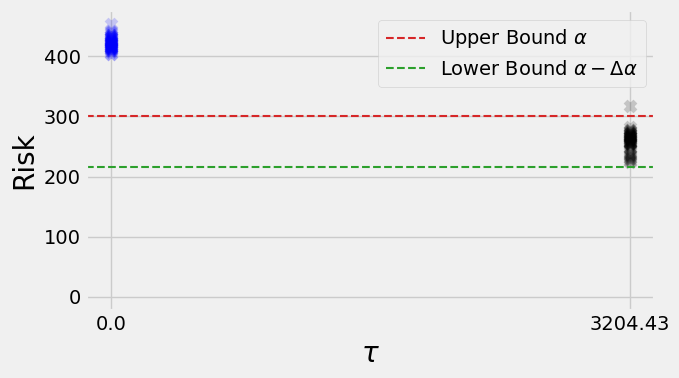

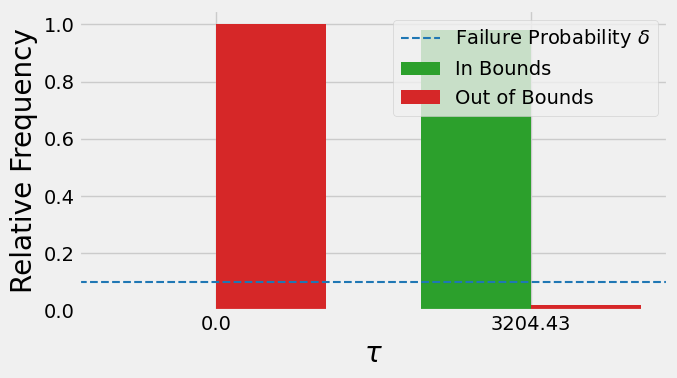

In [33]:
from rcpp.main import plot_final_loss_vs_iteration

plot_final_loss_vs_iteration(
    [0.0, round(tau, 2)],
    [trajs_uncontrolled, trajs_controlled],
    ['blue', 'black'],
    args,
    save_dir='./applications/forecasting/figures/'    
)

In [34]:
from rcpp.main import plot_lambda_vs_iteration

Saved lambda plot to ./applications/forecasting/figures/lambda_vs_iteration.pdf
Saved lambda diff plot to ./applications/forecasting/figures/lambda_diff_vs_iteration.pdf


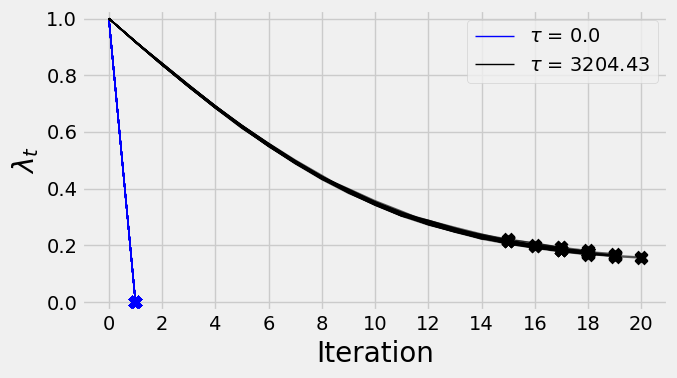

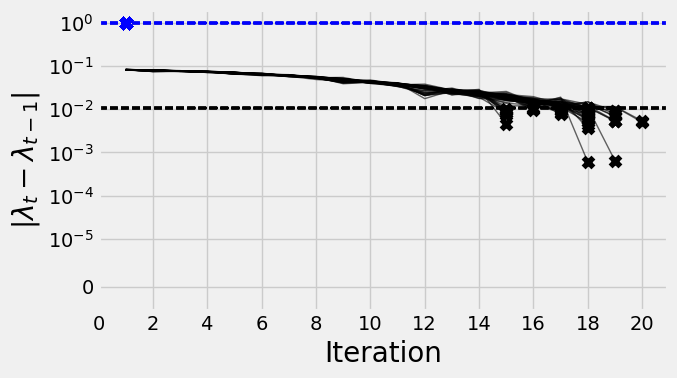

In [35]:
plot_lambda_vs_iteration(
    [0.0, round(tau, 2)],
    [trajs_uncontrolled, trajs_controlled],
    ['blue', 'black'],
    args,
    save_dir='./applications/forecasting/figures/',
    plot_all=True,
)

Saved loss plot to ./applications/forecasting/figures/loss_vs_iteration_3204_43.pdf


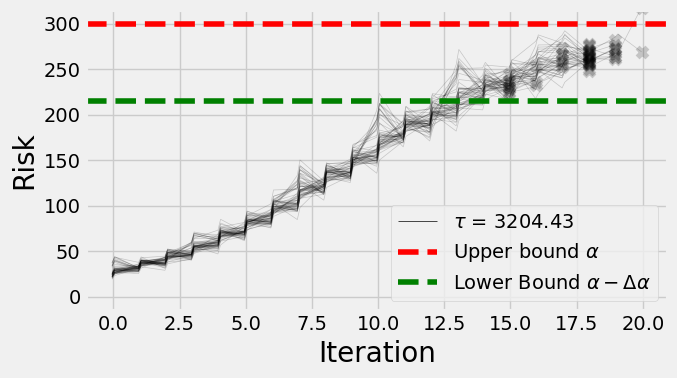

In [36]:
from rcpp.main import plot_loss_vs_iteration

plot_loss_vs_iteration(
    round(tau, 2),
    trajs_controlled,
    'black',
    args,
    save_dir='./applications/forecasting/figures/'
)